In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import pandas as pd
import numpy as np
from IPython.display import display

In [3]:
import spacy

spacy.prefer_gpu()

True

In [4]:
nlp = spacy.load("en_core_web_lg")

In [5]:
import pickle
with open('../pickles/data_cleaned.pickle', 'rb') as handle:
    data_cleaned = pickle.load(handle)

In [131]:
data_cleaned['RS_2020_confessions'].sort_values(by=['score'], ascending = False)

,id,score,selftext,title,title_language,selftext_language
10166,g0ffx4,6990,"When I was eleven, my mum gave birth to my lit...",We swapped our twin brothers at birth.,en,en
9877,g1eizr,4303,So I know I sound like a horrible person from ...,I send my cousins husband pictures of my boobs...,en,en
9983,g12gu5,4094,"I am a guy, and I have always been jealous of ...",I finally gave myself the courage to do it,en,en
27090,ej9uar,3061,$1000 in fake money came in the mail today. I'...,I bought movie money with the intention of spe...,en,en
10318,fzy078,2840,Am I an actual functioning alcoholic? Should I...,Since I've been working from home with the sta...,en,en
...,...,...,...,...,...,...
12698,frb4aa,0,I've been quarantined with a few of my roommat...,I Fucked My Roommate,en,en
12696,frb6cg,0,"I'm a pre-op trans guy, 6 years into medical t...",I want to fuck my father-in-law,en,en
12695,frbg0a,0,When I was around 7-9 years old I was at my na...,My younger siblings and cousins got sucked of ...,en,en
12684,frch7u,0,She already rejected my feelings and friendzon...,Fine. I will feel better about it now. I am ac...,en,en


In [136]:
test = data_cleaned['RS_2020_confessions'].sort_values(by=['score'], ascending = False).iloc[0].selftext
doc = nlp(test)
print(sum(1 for _ in doc.sents)) # print # of sentences
print(test[:500])

24
When I was eleven, my mum gave birth to my little brothers (identical twin boys). My sister and I (also identical twins), decided it would be funny to swap them. They had bands on their wrist identifying them but we were able to ease them off and swap them. We then placed them in each other's cribs. We did it because we thought our parents would realise straight away and laugh since they were able to tell us apart even when we swapped clothes. However, they didn't. 

A while later (possibly a fe


In [137]:
from sentence_transformers import SentenceTransformer, util
import torch

embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# https://www.pnas.org/content/pnas/114/38/E7900.full.pdf
# 27 emotions
# Corpus with example sentences
emotions = ['Admiration',
            'Adoration',
            'Aesthetic Appreciation',
            'Amusement',
            'Anxiety',
            'Awe',
            'Awkwardness',
            'Boredom',
            'Calmness',
            'Confusion',
            'Craving',
            'Disgust',
            'Empathetic pain',
            'Entrancement',
            'Envy',
            'Excitement',
            'Fear',
            'Horror',
            'Interest',
            'Joy',
            'Nostalgia',
            'Romance',
            'Sadness',
            'Satisfaction',
            'Sexual desire',
            'Sympathy',
            'Triumph',
          ]
emotions_embeddings = embedder.encode(emotions, convert_to_tensor=True)

# sentences in a document
sentences = [repr(sent) for sent in doc.sents]
# sentences = ['A man held a knife and cut his fingers.', 
#              'A woman held a knife and cut her fingers.', 
#             'The body is bleeding.']

sents_emotion_vec = []

for sentence in sentences:
    sentence_embedding = embedder.encode(sentence, convert_to_tensor=True)
    cos_scores = util.pytorch_cos_sim(sentence_embedding, emotions_embeddings)[0]
    cos_scores = cos_scores.cpu()

    #We use torch.topk to find the highest 5 scores
    #top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n")
    print("Query:", sentence)
    print("\nSimilarities between query sentence and 27 emotions:")

    sent_emotion_vec = []
#     for emotion, score in sorted(zip(emotions, cos_scores), key = lambda t: t[1], reverse= True):
    for emotion, score in zip(emotions, cos_scores):
        print(emotion.strip(), "(Score: %.4f)" % (score))
        sent_emotion_vec.append(score.numpy().item())
        
    sents_emotion_vec.append(sent_emotion_vec)




Query: When I was eleven, my mum gave birth to my little brothers (identical twin boys).

Similarities between query sentence and 27 emotions:
Admiration (Score: -0.1017)
Adoration (Score: -0.0699)
Aesthetic Appreciation (Score: -0.1179)
Amusement (Score: -0.1273)
Anxiety (Score: -0.0644)
Awe (Score: -0.0962)
Awkwardness (Score: -0.0413)
Boredom (Score: -0.2176)
Calmness (Score: -0.1454)
Confusion (Score: -0.1597)
Craving (Score: -0.0899)
Disgust (Score: -0.2354)
Empathetic pain (Score: -0.1359)
Entrancement (Score: 0.0911)
Envy (Score: -0.0091)
Excitement (Score: -0.0557)
Fear (Score: -0.1807)
Horror (Score: -0.1950)
Interest (Score: -0.0586)
Joy (Score: -0.0512)
Nostalgia (Score: -0.0865)
Romance (Score: 0.1255)
Sadness (Score: -0.1926)
Satisfaction (Score: -0.1524)
Sexual desire (Score: 0.0581)
Sympathy (Score: -0.1798)
Triumph (Score: -0.0132)



Query: My sister and I (also identical twins), decided it would be funny to swap them.

Similarities between query sentence and 27 emo

In [179]:
df = pd.DataFrame(sents_emotion_vec)
# df.columns = emotions
display(df)
df_t = df.transpose().reset_index().set_index('index')
df_t

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,-0.101740,-0.069851,-0.117916,-0.127272,-0.064382,-0.096156,-0.041279,-0.217636,-0.145439,-0.159683,...,-0.194993,-0.058649,-0.051152,-0.086539,0.125546,-0.192580,-0.152445,0.058052,-0.179762,-0.013152
1,0.141095,0.115507,0.059148,0.134976,-0.113776,0.051554,0.022576,0.005103,-0.093195,-0.158705,...,-0.182674,0.061666,0.109621,0.112945,0.382180,-0.175972,0.113496,0.136287,-0.015921,0.023377
2,0.200366,0.178749,0.134271,0.126128,0.100583,0.100931,0.044610,0.022027,0.044221,-0.005409,...,-0.019721,0.214899,0.082154,0.186783,0.134185,0.005506,0.167534,0.138142,0.047176,0.130821
3,0.126693,0.160706,0.063799,0.177872,-0.112027,0.052636,0.049315,0.050806,0.084486,0.108195,...,-0.119914,0.161798,0.083896,0.175606,0.231320,-0.042177,0.248104,0.163677,0.134351,0.133726
4,-0.021167,0.055375,-0.025541,-0.091363,0.033150,-0.069638,-0.052723,-0.023974,0.038031,-0.047820,...,-0.029708,-0.099734,-0.010840,0.058320,0.014354,0.045559,-0.011272,-0.013177,0.123058,-0.067150
5,0.049796,0.066667,-0.043428,-0.007600,-0.101288,0.048513,-0.096123,-0.069242,-0.079522,-0.207762,...,-0.195894,-0.000928,0.038352,0.012804,0.171480,-0.192510,-0.029830,0.018814,-0.080389,-0.030926
6,0.180277,0.202308,0.052176,0.232997,0.136921,0.189144,0.300393,0.393853,0.417054,0.387785,...,0.252575,0.246798,0.106033,0.289863,0.268372,0.341752,0.214209,0.181377,0.203049,0.147607
7,-0.107670,-0.123839,-0.130368,-0.046244,0.267825,-0.095638,0.154026,0.131764,-0.061518,0.175091,...,0.116781,0.021998,-0.099854,0.077960,0.144501,0.143504,-0.107775,0.167409,0.017784,-0.127884
8,0.149977,0.074237,0.054891,0.205476,0.526194,0.150899,0.483898,0.199414,0.080067,0.568394,...,0.480230,0.280087,0.139377,0.119636,0.178164,0.298214,0.127377,0.217870,0.223020,0.204250
9,-0.229612,-0.207803,-0.125300,-0.200837,-0.047107,-0.232459,-0.057731,-0.074957,-0.173264,-0.095826,...,-0.181922,-0.121304,-0.227879,-0.026881,0.025729,-0.119133,-0.260425,0.008899,-0.126879,-0.256361


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
index,,,,,,,,,,,,,,,,,,,,,
0,-0.101740,0.141095,0.200366,0.126693,-0.021167,0.049796,0.180277,-0.107670,0.149977,-0.229612,...,-0.045015,0.125123,0.420238,-0.108050,0.240262,0.111323,-0.128773,-0.162888,0.058464,-0.033020
1,-0.069851,0.115507,0.178749,0.160706,0.055375,0.066667,0.202308,-0.123839,0.074237,-0.207803,...,-0.078422,0.162414,0.441339,-0.059607,0.278808,0.128873,-0.081218,-0.162537,0.021142,-0.071527
2,-0.117916,0.059148,0.134271,0.063799,-0.025541,-0.043428,0.052176,-0.130368,0.054891,-0.125300,...,-0.088163,0.242089,0.435219,-0.043342,0.123942,0.130883,-0.101655,-0.191619,0.109997,-0.028069
3,-0.127272,0.134976,0.126128,0.177872,-0.091363,-0.007600,0.232997,-0.046244,0.205476,-0.200837,...,-0.050842,0.084636,0.226122,-0.102148,0.187229,0.124652,-0.204994,-0.133113,-0.070655,-0.071104
4,-0.064382,-0.113776,0.100583,-0.112027,0.033150,-0.101288,0.136921,0.267825,0.526194,-0.047107,...,0.091678,0.055707,0.001214,-0.022413,0.181753,0.284806,0.013637,0.119998,0.294687,0.069121
5,-0.096156,0.051554,0.100931,0.052636,-0.069638,0.048513,0.189144,-0.095638,0.150899,-0.232459,...,-0.017169,0.098266,0.241198,-0.089372,0.307599,0.052621,-0.111585,-0.125380,0.003022,-0.116526
6,-0.041279,0.022576,0.044610,0.049315,-0.052723,-0.096123,0.300393,0.154026,0.483898,-0.057731,...,0.070793,0.193413,-0.003455,-0.090086,0.231946,0.038721,-0.012878,0.099713,0.290406,-0.072751
7,-0.217636,0.005103,0.022027,0.050806,-0.023974,-0.069242,0.393853,0.131764,0.199414,-0.074957,...,0.137761,0.054200,0.095454,-0.056647,-0.040210,0.253395,-0.088034,0.100196,0.073875,0.050670
8,-0.145439,-0.093195,0.044221,0.084486,0.038031,-0.079522,0.417054,-0.061518,0.080067,-0.173264,...,-0.031785,0.155704,0.253181,-0.073832,0.121182,0.170126,-0.015647,-0.117469,0.040791,0.039003


(-0.2, 0.6)

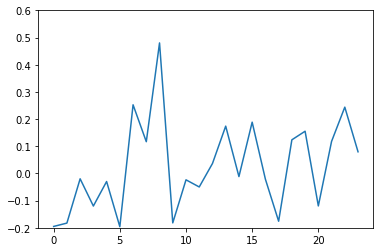

In [157]:
import matplotlib.pyplot as plt

g = df_t.loc['Horror',:]
ax = g.plot()
# ax.set_xticks(range(len(g)))
# ax.set_xticklabels([item for item in g.index.tolist()], rotation=90)
ax.set_ylim(-0.2, 0.6)

In [149]:
import seaborn as sns
df.reset_index()

,index,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,Admiration,-0.101740,0.141095,0.200366,0.126693,-0.021167,0.049796,0.180277,-0.107670,0.149977,...,-0.045015,0.125123,0.420238,-0.108050,0.240262,0.111323,-0.128773,-0.162888,0.058464,-0.033020
1,Adoration,-0.069851,0.115507,0.178749,0.160706,0.055375,0.066667,0.202308,-0.123839,0.074237,...,-0.078422,0.162414,0.441339,-0.059607,0.278808,0.128873,-0.081218,-0.162537,0.021142,-0.071527
2,Aesthetic Appreciation,-0.117916,0.059148,0.134271,0.063799,-0.025541,-0.043428,0.052176,-0.130368,0.054891,...,-0.088163,0.242089,0.435219,-0.043342,0.123942,0.130883,-0.101655,-0.191619,0.109997,-0.028069
3,Amusement,-0.127272,0.134976,0.126128,0.177872,-0.091363,-0.007600,0.232997,-0.046244,0.205476,...,-0.050842,0.084636,0.226122,-0.102148,0.187229,0.124652,-0.204994,-0.133113,-0.070655,-0.071104
4,Anxiety,-0.064382,-0.113776,0.100583,-0.112027,0.033150,-0.101288,0.136921,0.267825,0.526194,...,0.091678,0.055707,0.001214,-0.022413,0.181753,0.284806,0.013637,0.119998,0.294687,0.069121
5,Awe,-0.096156,0.051554,0.100931,0.052636,-0.069638,0.048513,0.189144,-0.095638,0.150899,...,-0.017169,0.098266,0.241198,-0.089372,0.307599,0.052621,-0.111585,-0.125380,0.003022,-0.116526
6,Awkwardness,-0.041279,0.022576,0.044610,0.049315,-0.052723,-0.096123,0.300393,0.154026,0.483898,...,0.070793,0.193413,-0.003455,-0.090086,0.231946,0.038721,-0.012878,0.099713,0.290406,-0.072751
7,Boredom,-0.217636,0.005103,0.022027,0.050806,-0.023974,-0.069242,0.393853,0.131764,0.199414,...,0.137761,0.054200,0.095454,-0.056647,-0.040210,0.253395,-0.088034,0.100196,0.073875,0.050670
8,Calmness,-0.145439,-0.093195,0.044221,0.084486,0.038031,-0.079522,0.417054,-0.061518,0.080067,...,-0.031785,0.155704,0.253181,-0.073832,0.121182,0.170126,-0.015647,-0.117469,0.040791,0.039003
9,Confusion,-0.159683,-0.158705,-0.005409,0.108195,-0.047820,-0.207762,0.387785,0.175091,0.568394,...,0.020151,0.230594,-0.018000,-0.121744,0.316345,0.077315,-0.042090,0.122530,0.370293,-0.028121


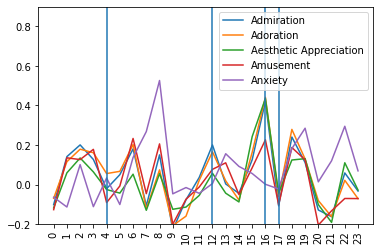

In [171]:
for i in range(0, sum(1 for _ in doc.sents), 5):
    g = df.iloc[:,i:i+5]
    ax = g.plot()
    ax.set_xticks(range(len(g)))
    ax.set_xticklabels([item for item in g.index.tolist()], rotation=90)
    ax.set_ylim(-0.2, 0.9)
    ax.axvline(x=4)
    ax.axvline(x=12)
    ax.axvline(x=16)
    ax.axvline(x=17)
    ax.figure.savefig(f'../Presentations/11-16-2020/gif-confessions/{i}.png')
    break

In [129]:
len(list(range(0, sum(1 for _ in doc.sents),5)))

65

In [153]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

df = pd.DataFrame(columns=["Event1", "Event2", "Event3"], 
                                data=[[15,1,22],
                                      [16,1.26,80],
                                      [27,0,15]])
df = df.set_index([["Series1", "Series2", "Series3"]])
print(df)

         Event1  Event2  Event3
Series1      15    1.00      22
Series2      16    1.26      80
Series3      27    0.00      15


     Sentences  Emotions    Values
0            0         0 -0.101740
1            0         1 -0.069851
2            0         2 -0.117916
3            0         3 -0.127272
4            0         4 -0.064382
..         ...       ...       ...
643         23        22  0.057239
644         23        23 -0.000190
645         23        24  0.003830
646         23        25  0.071683
647         23        26 -0.048943

[648 rows x 3 columns]


C:\Users\Antho\anaconda3\envs\creepyvenv\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


<Figure size 864x576 with 0 Axes>

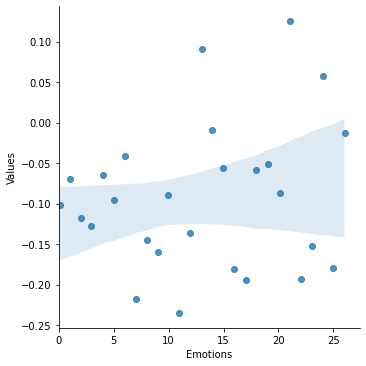

In [190]:
# reorganize df to classic table
df2=df.stack().reset_index()
df2.columns = ['Sentences','Emotions','Values']
print(df2)

plt.figure(figsize=(12,8))
ax = sns.lmplot(x='Emotions', y='Values',data=df2[df2.Sentences == 0], x_jitter=.1)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [178]:
sns.load_dataset("tips")

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [ ]:
import seaborn as sns; sns.set_theme(color_codes=True)
tips = sns.load_dataset("tips")
ax = sns.regplot(x="total_bill", y="tip", data=tips)